In [23]:
from configparser import ConfigParser
from pathlib import Path
import os
cfgparser = ConfigParser()
cfgparser.read("configs/default_small_env.ini")
dict(cfgparser.items("EnvConfig"))
cfgparser.getint("EnvConfig", "size_i")

20

In [1]:
import sys
# sys.path.insert(0, "..")

In [2]:
import io

import numpy as np
import ray
from ray.rllib.agents import ppo
from ray.tune.registry import register_env
from ray.tune.logger import UnifiedLogger
from gym.spaces import Discrete, Box

from cpr_reputation.environments import HarvestEnv
from cpr_reputation.utils import retrieve_checkpoint

defaults_ini = {
    "num_agents": 4,
    "size": (20, 20),
    "sight_width": 5,
    "sight_dist": 10,
    "num_crosses": 4,
}

register_env("harvest", lambda config: HarvestEnv(config, **defaults_ini))

walker1 = (
    None,
    Box(
        0.0,
        1.0,
        (defaults_ini["sight_dist"], 2 * defaults_ini["sight_width"] + 1, 3),
        np.float32,
    ),  # obs
    Discrete(8),  # action
    dict(),
)

walkers = {f"Agent{k}": walker1 for k in range(defaults_ini["num_agents"])}

config = {
    "multiagent": {
        "policies": walkers,
        "policy_mapping_fn": lambda agent_id: agent_id,
        "policies_to_train": list(walkers.keys())
    },
    "framework": "torch",
    "model": {
        "dim": 3,
        "conv_filters": [
            [16, [4, 4], 1],
            [
                32,
                [defaults_ini["sight_dist"], 2 * defaults_ini["sight_width"] + 1],
                1,
            ],
        ],
    },
}



In [ ]:
ray.init()
trainer = ppo.PPOTrainer(
    env="harvest",
    config=config,
    logger_creator=lambda cfg: UnifiedLogger(cfg, "log"),
)


In [10]:
#trainer.env_creator(config).game.reputation

{'Agent0': 0, 'Agent1': 0, 'Agent2': 0, 'Agent3': 0}

In [ ]:
results = trainer.train()
trainer.env_creator(config).game.reputation

In [5]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_allow_unknown_configs',
 '_allow_unknown_subkeys',
 '_before_evaluate',
 '_close_logfiles',
 '_create_logger',
 '_default_config',
 '_env_id',
 '_episodes_total',
 '_evaluate',
 '_experiment_id',
 '_export_model',
 '_init',
 '_is_overridden',
 '_iteration',
 '_iterations_since_restore',
 '_local_ip',
 '_log_result',
 '_logdir',
 '_make_workers',
 '_monitor',
 '_name',
 '_open_logfiles',
 '_override_all_subkeys_if_type_changes',
 '_policy_class',
 '_register_if_needed',
 '_restore',
 '_restored',
 '_result_logger',
 '_save',
 '_setup',
 '_stderr_context',
 '_stderr_fp',
 '_stderr_logging

In [10]:
trainer.save("ckpnts")

'ckpnts/checkpoint_1/checkpoint-1'

In [11]:
# trainer.export_policy_model("log", "Agent1")

# with io.open("saved.obj", "wb") as f: 
#     f.write(trainer.save_to_object())

# with io.open("saved.obj", "rb") as f: 
#     trainer.restore_from_object(f.read())

trainer.restore("ckpnts/checkpoint_1/checkpoint-1")

2021-04-14 21:58:56,370	INFO trainable.py:371 -- Restored on 192.168.8.108 from checkpoint: ckpnts/checkpoint_1/checkpoint-1
2021-04-14 21:58:56,372	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 128.09879994392395, '_episodes_total': 2}


In [15]:
trainer.config["multiagent"]["policies"]

{'Agent0': (ray.rllib.policy.policy_template.PPOTorchPolicy,
  Box(0.0, 1.0, (10, 11, 3), float32),
  Discrete(8),
  {}),
 'Agent1': (ray.rllib.policy.policy_template.PPOTorchPolicy,
  Box(0.0, 1.0, (10, 11, 3), float32),
  Discrete(8),
  {}),
 'Agent2': (ray.rllib.policy.policy_template.PPOTorchPolicy,
  Box(0.0, 1.0, (10, 11, 3), float32),
  Discrete(8),
  {}),
 'Agent3': (ray.rllib.policy.policy_template.PPOTorchPolicy,
  Box(0.0, 1.0, (10, 11, 3), float32),
  Discrete(8),
  {})}

# Fuck it. writing a render function. 

With trainer.compute_actions, and other stuff like that

In [36]:
class HarvestRecorder(HarvestEnv): 
    def __init__(
        self, 
        config: dict, 
        trainer, 
        checkpoints_superdir: str = "ckpnts", 
        checkpoint_no: int = 1, 
        **kwargs
    ): 
        super().__init__(config, **kwargs)
        self.checkpoints_superdir = checkpoints_superdir
        self.trainer = trainer
        try: 
            trainer.restore(f"{checkpoints_superdir}/checkpoint_{checkpoint_no}/checkpoint-{checkpoint_no}")
            print(f"Loaded in checkpoint {checkpoint_no}")
        except: 
            print(f"Not loading any checkpoint at all, tried checkpoint {checkpoint_no}")
        self.checkpoint_no = checkpoint_no
        import matplotlib.pyplot as plt
        from celluloid import Camera
        self.plt = plt
        self.Camera = Camera
        import matplotlib as mpl
        self.cmap = mpl.colors.ListedColormap(["white", "red", "green" , "grey"])
        
    def record(self, filename: str = None):
        import matplotlib.animation as animation
        
        if not filename: 
            filename = f"harvest-anim-{self.checkpoint_no}.mp4"
        fig, ax = self.plt.subplots()
        obs = self.reset()
        images = list()
        while True: 
            actions = self.trainer.compute_actions(
                obs, 
                policy_id="Agent0"
            )
            obs, rewards, done, info = self.step(actions)
            
            
            board = self.game.board.copy()
            for _, agent in self.game.agents.items(): 
                board[agent.pos] = 2
            board[self.game.walls.astype(bool)] = 3
            im = ax.imshow(board, cmap=self.cmap)
            images.append([im])
            
            
            if done["__all__"]: 
                break
        ani = animation.ArtistAnimation(fig, images, interval=50, blit=True, repeat_delay=10000)
        ani.save(filename)

In [27]:
# ?recorder.trainer.compute_actions

# recorder.trainer.get_policy("Agent0")

2021-04-14 23:08:35,204	INFO trainable.py:371 -- Restored on 192.168.8.108 from checkpoint: ckpnts/checkpoint_1/checkpoint-1
2021-04-14 23:08:35,213	INFO trainable.py:379 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 128.09879994392395, '_episodes_total': 2}


Loaded in checkpoint 1


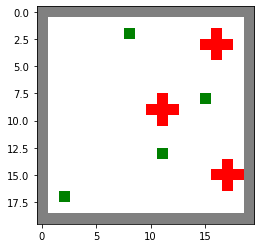

In [37]:
recorder = HarvestRecorder(config, trainer, **defaults_ini)

recorder.record()

In [35]:
while True: 
    actions = recorder.trainer.compute_actions(
        obs, 
        policy_id="Agent0"
    )
    obs, rewards, done, info = self.step(actions)
    board = recorder.game.board.copy()
    for _, agent in recorder.game.agents.items(): 
        board[agent.pos] = 2
    board[self.game.walls.astype(bool)] = 3
    ax.cla()
    ax.imshow(board, cmap=self.cmap)
    camera.snap()
    if done["__all__"]: 
        break
animation = camera.animate()
animation.save(filename)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
5,3,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,3
6,3,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
7,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
8,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
9,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [69]:
import pandas as pd
!ls log

checkpoint-1
events.out.tfevents.1616797063.quinn-Latitude-3340
events.out.tfevents.1616798483.quinn-Latitude-3340
events.out.tfevents.1616941169.quinn-Latitude-3340
events.out.tfevents.1616941192.quinn-Latitude-3340
events.out.tfevents.1616943650.quinn-Latitude-3340
events.out.tfevents.1616953298.quinn-Latitude-3340
events.out.tfevents.1616957917.quinn-Latitude-3340
events.out.tfevents.1616958578.quinn-Latitude-3340
events.out.tfevents.1616959652.quinn-Latitude-3340
events.out.tfevents.1616959673.quinn-Latitude-3340
events.out.tfevents.1616960168.quinn-Latitude-3340
events.out.tfevents.1616960182.quinn-Latitude-3340
events.out.tfevents.1616960208.quinn-Latitude-3340
events.out.tfevents.1616960247.quinn-Latitude-3340
events.out.tfevents.1616960357.quinn-Latitude-3340
params.json
params.pkl
progress.csv
result.json


In [76]:
pd.read_csv("log/progress.csv", header=None)

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,16.0,11.0,13.500000,1002.0,2,2,4000,False,2,1,...,0.0,0.2,0.00005,0.334471,-0.051019,0.383098,0.440263,0.011957,2.065266,0.0
1,16.0,8.0,12.333333,1002.0,4,2,8000,False,6,2,...,0.0,0.2,0.00005,0.136420,-0.052705,0.185611,0.558235,0.017568,2.040155,0.0
2,16.0,8.0,11.600000,1002.0,4,2,12000,False,10,3,...,0.0,0.2,0.00005,0.291126,-0.059521,0.347306,0.527838,0.016709,2.021533,0.0
3,11.0,7.0,9.000000,1002.0,2,2,4000,False,2,1,...,0.0,0.2,0.00005,0.027325,-0.038971,0.064254,0.497110,0.010209,2.066390,0.0
4,11.0,7.0,9.000000,1002.0,2,2,4000,False,2,1,...,0.0,0.2,0.00005,0.027325,-0.038971,0.064254,0.497110,0.010209,2.066390,0.0
5,9.0,3.0,6.000000,1002.0,2,2,4000,False,2,1,...,0.0,0.2,0.00005,-0.024132,-0.029238,0.002606,0.750254,0.012500,2.063753,0.0


In [78]:
!ls -l log

total 5576
-rw-rw-r-- 1 quinn quinn 5508984 Mar 28 20:06 checkpoint-1
-rw-rw-r-- 1 quinn quinn   11530 Mar 26 22:24 events.out.tfevents.1616797063.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn      40 Mar 26 22:41 events.out.tfevents.1616798483.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn      40 Mar 28 15:19 events.out.tfevents.1616941169.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn      40 Mar 28 15:19 events.out.tfevents.1616941192.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn      40 Mar 28 16:02 events.out.tfevents.1616943650.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn   61791 Mar 28 18:50 events.out.tfevents.1616953298.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn   11812 Mar 28 20:04 events.out.tfevents.1616957917.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn   11812 Mar 28 20:10 events.out.tfevents.1616958578.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn       0 Mar 28 20:27 events.out.tfevents.1616959652.quinn-Latitude-3340
-rw-rw-r-- 1 quinn quinn       0 Mar 28 20:27 events.out.

In [84]:
import json
import io

# with io.open("log/result.json") as file: 
#    all_results = json.load(file)
    

In [115]:
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.policy import Policy
from typing import Dict

class SaveCheckpointsCallback(DefaultCallbacks): 
    
    def on_episode_end(
        self, *, 
        worker: RolloutWorker, 
        base_env: BaseEnv,
        policies: Dict[str, Policy], 
        episode: MultiAgentEpisode,
        env_index: int, 
        **kwargs
    ):
        for agent_id, policy in policies.items(): 
            policy.export_model(f"log/{agent_id}")
            
        if self.legacy_callbacks.get("on_episode_end"):
            self.legacy_callbacks["on_episode_end"]({
                "env": base_env,
                "policy": policies,
                "episode": episode,
            })

In [122]:

config = {
    "multiagent": {
        "policies": walkers,
        "policy_mapping_fn": lambda agent_id: agent_id,
        "policies_to_train": list(walkers.keys()), 
        "checkpoint_at_end": True
    },
    "framework": "torch",
    "model": {
        "dim": 3,
        "conv_filters": [
            [16, [4, 4], 1],
            [
                32,
                [defaults_ini["sight_dist"], 2 * defaults_ini["sight_width"] + 1],
                1,
            ],
        ],
    },
    #"callbacks": SaveCheckpointsCallback
}


In [123]:

trainer = ppo.PPOTrainer(
    env="harvest",
    config=config,
    logger_creator=lambda cfg: UnifiedLogger(cfg, "log"),
)



2021-03-28 21:31:12,229	WARNING worker.py:1107 -- The actor or task with ID ffffffffffffffff1527e7240dfab35c3db907a401000000 cannot be scheduled right now. It requires {CPU: 1.000000} for placement, but this node only has remaining {0.000000/4.000000 CPU, 2.783203 GiB/2.783203 GiB memory, 0.927734 GiB/0.927734 GiB object_store_memory, 1.000000/1.000000 node:10.8.3.4}
. In total there are 0 pending tasks and 2 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


KeyboardInterrupt: 

In [ ]:

while True:
    results = trainer.train()
    

In [10]:
ls -l ~/ray_results | grep train_fn

drwxrwxr-x 3 quinn quinn 4096 Mar 29 13:15 train_fn_2021-03-29_13-12-41/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 13:28 train_fn_2021-03-29_13-28-25/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 13:32 train_fn_2021-03-29_13-29-19/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 13:36 train_fn_2021-03-29_13-36-22/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:03 train_fn_2021-03-29_13-37-56/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:07 train_fn_2021-03-29_14-04-40/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:10 train_fn_2021-03-29_14-07-31/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:10 train_fn_2021-03-29_14-10-21/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:22 train_fn_2021-03-29_14-22-46/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:23 train_fn_2021-03-29_14-23-38/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:24 train_fn_2021-03-29_14-24-38/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:25 train_fn_2021-03-29_14-25-27/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:26 train_fn_2021-03-29_14-26-50/
drwxrwxr-x 3 quinn quinn 4096 Mar 29 14:31 train_fn

In [25]:
import os

def all_dirs_under(path):
    """Iterates through all files that are under the given path."""
    for cur_path, dirnames, filenames in os.walk(path):
        for dir_ in dirnames: 
            yield os.path.join(cur_path, dir_)

def latest_dir(path): 
    return max(all_dirs_under(path), key=os.path.getmtime)

to_restore = latest_dir("//home/quinn/ray_results")
to_restore

'//home/quinn/ray_results/train_fn_2021-03-29_17-18-24'

In [42]:
def walk_to_checkpoint(to_restore_path: str): 
    for cur_path, dirnames, _ in os.walk(to_restore_path): 
        for dir_ in dirnames: 
            if dir_.startswith("train_fn_"):
                # print(os.path.join(cur_path, dir_))
                for cur_path_, dirnames_, _ in os.walk(os.path.join(cur_path, dir_)): 
                    for dir__ in dirnames_:                     
                        if dir__.startswith("checkpoint_"): 
                            return os.path.join(cur_path_, dir__)

checkpoint = walk_to_checkpoint(
    latest_dir(
        "//home/quinn/ray_results"
    )
)
checkpoint

In [70]:
from typing import List

def retrieve_checkpoint(path: str = "//home/quinn/ray_results", prefix: str = "train_fn") -> str: 

    def all_dirs_under(path):
        """Iterates through all files that are under the given path."""
        for cur_path, dirnames, filenames in os.walk(path):
            for dir_ in dirnames: 
                yield os.path.join(cur_path, dir_)

    def retrieve_checkpoints(paths: List[str]) -> List[str]:
        checkpoints = list()
        for path in paths: 
            for cur_path, dirnames, _ in os.walk(path): 
                for dirname in dirnames: 
                    if dirname.startswith("checkpoint_"): 
                        checkpoints.append(os.path.join(cur_path, dirname))
        return checkpoints
    
    sorted_checkpoints = retrieve_checkpoints(
        sorted(
            filter(
                lambda x: x.startswith(f"{path}/{prefix}"), all_dirs_under(path)
            ), 
            key=os.path.getmtime
        )
    )[::-1]
    
    for checkpoint in sorted_checkpoints:
        if checkpoint is not None: 
            return checkpoint
    return None

retrieve_checkpoint()

'//home/quinn/ray_results/train_fn_2021-03-29_20-08-33/train_fn_28297_00000_0_2021-03-29_20-08-33/checkpoint_tmp095c77'

In [60]:
!ls -la //home/quinn/ray_results/train_fn_2021-03-29_20-08-33/train_fn_28297_00000_0_2021-03-29_20-08-33/checkpoint_tmp095c77/

total 12
drwxrwxr-x 2 quinn quinn 4096 Mar 29 20:08 .
drwxrwxr-x 4 quinn quinn 4096 Mar 29 20:08 ..
-rw-rw-r-- 1 quinn quinn    0 Mar 29 20:08 .is_checkpoint
-rw-rw-r-- 1 quinn quinn    0 Mar 29 20:08 .null_marker
-rw-rw-r-- 1 quinn quinn    0 Mar 29 20:08 .temp_marker
-rw-rw-r-- 1 quinn quinn  181 Mar 29 20:08 .tune_metadata


In [76]:
from numpy.random import permutation
permutation(list(map(lambda x: x == 5, [4,5,3])))

array([False, False,  True])

# toward video proof

In [2]:
from celluloid import Camera
from IPython.display import Video
import matplotlib.pyplot as plt
import numpy as np

from cpr_reputation import board
from cpr_reputation.utils import retrieve_checkpoint

In [5]:
checkpoint = retrieve_checkpoint("//home/quinn/ray_results")

In [7]:
# load checkpoint 
# run episode 
# with Camera calls in it
